In [4]:
%matplotlib inline

In [5]:
from nbodykit.algorithms.fftpower import FFTPower
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh
import numpy as np
from nbodykit.lab import FFTPower
import matplotlib.pyplot as plt

In [6]:
fastpm_folder_name='data_collection/mlsimdata19/results-fastpm-random_seed-136308-folder-mlsimdata19'
za_folder_name='data_collection/mlsimdata19/results-za-random_seed-136308-folder-mlsimdata19'
twolpt_folder_name='data_collection/mlsimdata19/results-2lpt-random_seed-136308-folder-mlsimdata19'
folder='mlsimdata19'
seed='136308'

In [7]:
import os
folder='mlsimdata19'
directory = '/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder
seeds = []
fastpm_folder_names = []
za_folder_names = []
twolpt_folder_names = []

# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Check if it is a file
    if os.path.isfile(os.path.join(directory, filename)):
        # Split the filename and remove the extension
        name, _ = os.path.splitext(filename)
        seeds.append(name)
        fastpm_folder_names.append('data_collection/'+folder+'/results-fastpm-random_seed-'+name+'-folder-'+folder)
        za_folder_names.append('data_collection/'+folder+'/results-za-random_seed-'+name+'-folder-'+folder)
        twolpt_folder_names.append('data_collection/'+folder+'/results-2lpt-random_seed-'+name+'-folder-'+folder)

In [8]:
model_path='/lustre/project/tkcastrosim/CKWan/ml/model_checkpoints/doubledatanoaugment/best-checkpoint-epoch=495.ckpt'

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


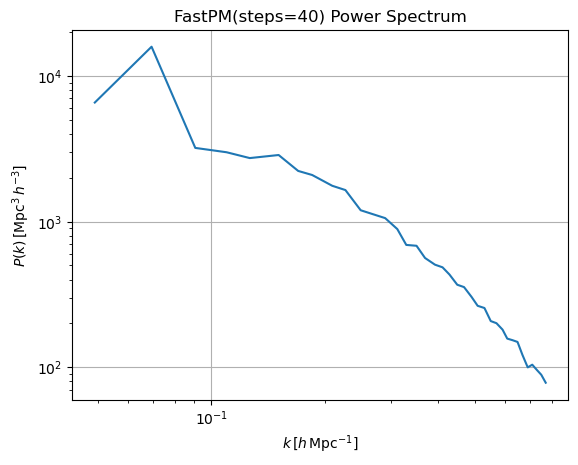

In [9]:
power_values_list = []
labels = [
    'fastpm-steps-40',
    '2lpt',
    'za',
    'unet'
]
fastpm_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_1.0000', dataset='1/', header='Header')
fastpm_mesh = fastpm_part.to_mesh(Nmesh=32,BoxSize=128)
fastpm_fft = FFTPower(fastpm_mesh, mode='1d', dk=0.02)

k_values = fastpm_fft.power['k']  # Array of k values
fastpm_power_values = fastpm_fft.power['power'].real 
power_values_list.append(fastpm_power_values)

plt.loglog(k_values, fastpm_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('FastPM(steps=40) Power Spectrum')
plt.grid(True)
plt.show()

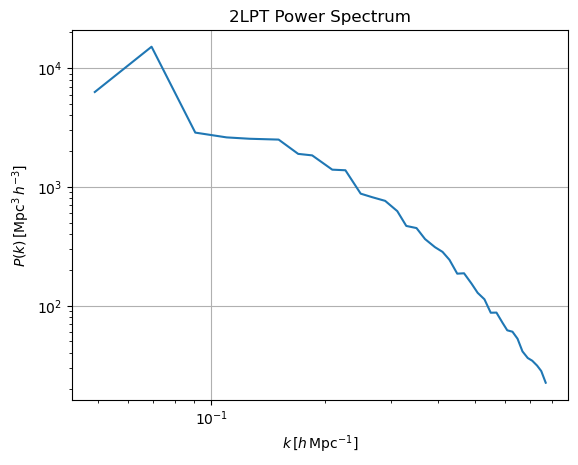

In [10]:
twolpt_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+twolpt_folder_name+'/fastpm_1.0000', dataset='1/', header='Header')
twolpt_mesh = twolpt_part.to_mesh(Nmesh=32,BoxSize=128)
twolpt_fft = FFTPower(twolpt_mesh, mode='1d', dk=0.02)

twolpt_power_values = twolpt_fft.power['power'].real 
power_values_list.append(twolpt_power_values)

plt.loglog(k_values, twolpt_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('2LPT Power Spectrum')
plt.grid(True)
plt.show()

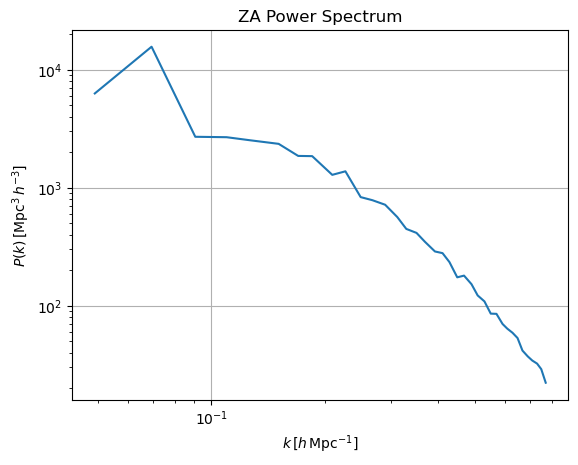

In [11]:
za_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+za_folder_name+'/fastpm_1.0000', dataset='1/', header='Header')
za_mesh = za_part.to_mesh(Nmesh=32,BoxSize=128)
za_fft = FFTPower(za_mesh, mode='1d', dk=0.02)

za_power_values = za_fft.power['power'].real 
power_values_list.append(za_power_values)

plt.loglog(k_values, za_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('ZA Power Spectrum')
plt.grid(True)
plt.show()

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


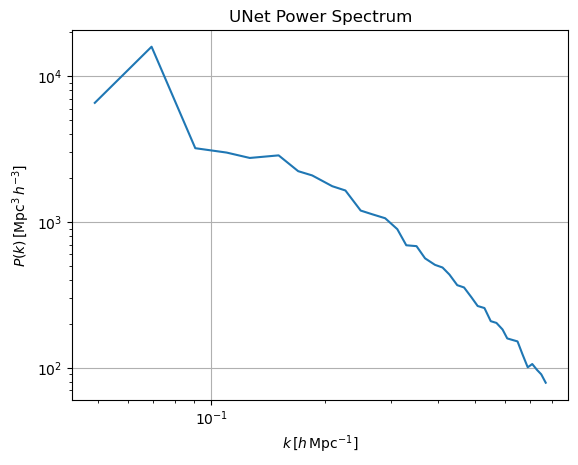

In [12]:
import torch
from nbodykit.source.catalog import ArrayCatalog

fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_0.0099', dataset='1/', header='Header')
fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)

from model1021 import Lpt2NbodyNetLightning
model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()
unet_displacement = model(za_tensor).squeeze(0).detach().numpy()

final_pos = pos_initial + unet_displacement
final_pos = final_pos.transpose(1, 2, 3, 0).reshape(32**3, 3)
unet_displacement = unet_displacement.transpose(1, 2, 3, 0)

data = np.empty(32**3, dtype=[('Position', ('f8', 3))])
data['Position'] = final_pos

unet_part = ArrayCatalog(data)
unet_mesh = unet_part.to_mesh(Nmesh=32,BoxSize=128)

unet_fft = FFTPower(unet_mesh, mode='1d', dk=0.02)
unet_power_values = unet_fft.power['power'].real 
power_values_list.append(unet_power_values)

plt.loglog(k_values, unet_power_values)
plt.xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.title('UNet Power Spectrum')
plt.grid(True)
plt.show()

In [13]:
from nbodykit.algorithms import SimulationBox3PCF
import numpy as np

poles = [0, 1, 2, 3, 4]
bins = np.linspace(0, 50, 11)

pcf = SimulationBox3PCF(unet_part, poles, bins, BoxSize=128)

results = pcf.run()

In [22]:
twolpt_pcf = SimulationBox3PCF(twolpt_part, poles, bins, BoxSize=128)

twolpt_results = twolpt_pcf.run()

In [24]:
fastpm_pcf = SimulationBox3PCF(fastpm_part, poles, bins, BoxSize=128)

fastpm_results = fastpm_pcf.run()

In [71]:
results.edges

{'r1': array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 'r2': array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])}

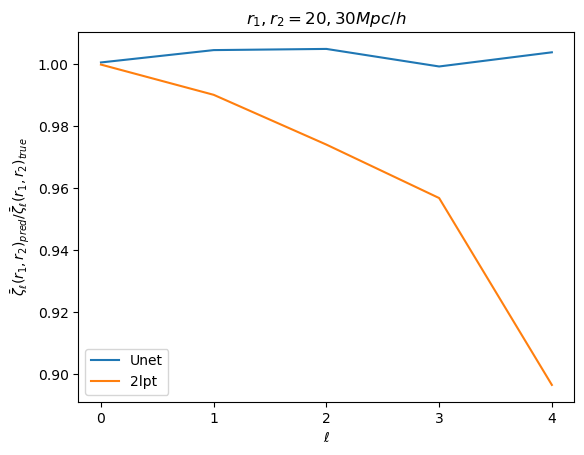

In [74]:
from matplotlib.ticker import MaxNLocator
results_array = np.squeeze(np.column_stack([results.data[3,5][field] for field in results.data[3,5].dtype.names]))
twolpt_results_array = np.squeeze(np.column_stack([twolpt_results.data[3,5][field] for field in twolpt_results.data[3,5].dtype.names]))
fastpm_results_array = np.squeeze(np.column_stack([fastpm_results.data[3,5][field] for field in fastpm_results.data[3,5].dtype.names]))

plt.figure()

plt.plot(poles, results_array / fastpm_results_array, label='Unet')  # Plot transfer function
plt.plot(poles, twolpt_results_array / fastpm_results_array, label='2lpt')  # Plot transfer function
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\bar{\zeta}_{\ell}(r_{1},r_{2})_{pred}/\bar{\zeta}_{\ell}(r_{1},r_{2})_{true}$')
plt.legend()
plt.title(r'$r_{1},r_{2}=20,30 Mpc/h$')
plt.show()

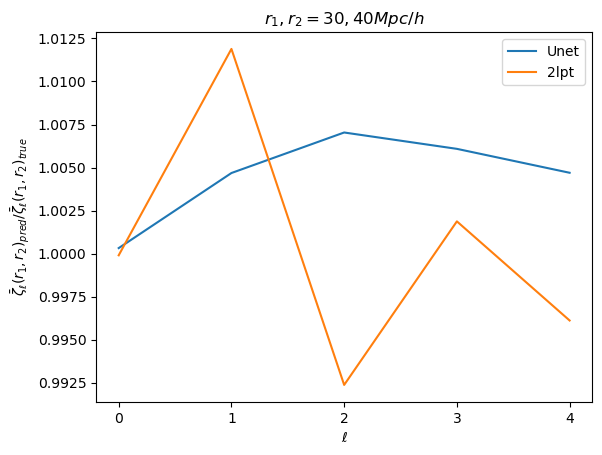

In [75]:
results_array = np.squeeze(np.column_stack([results.data[5,7][field] for field in results.data[5,7].dtype.names]))
twolpt_results_array = np.squeeze(np.column_stack([twolpt_results.data[5,7][field] for field in twolpt_results.data[5,7].dtype.names]))
fastpm_results_array = np.squeeze(np.column_stack([fastpm_results.data[5,7][field] for field in fastpm_results.data[5,7].dtype.names]))

plt.figure()

plt.plot(poles, results_array / fastpm_results_array, label='Unet')  # Plot transfer function
plt.plot(poles, twolpt_results_array / fastpm_results_array, label='2lpt')  # Plot transfer function
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\bar{\zeta}_{\ell}(r_{1},r_{2})_{pred}/\bar{\zeta}_{\ell}(r_{1},r_{2})_{true}$')
plt.legend()
plt.title(r'$r_{1},r_{2}=30,40 Mpc/h$')
plt.show()

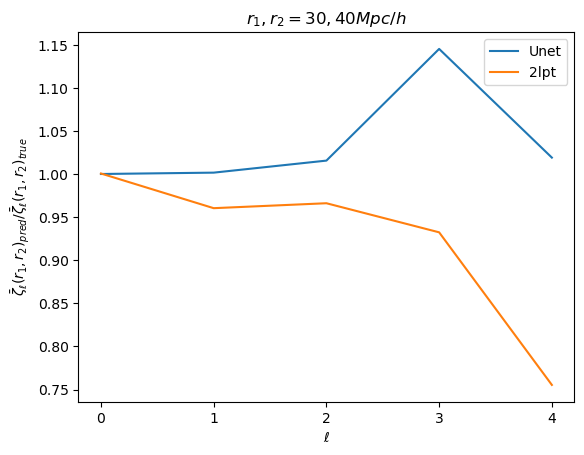

In [76]:
results_array = np.squeeze(np.column_stack([results.data[3,9][field] for field in results.data[3,9].dtype.names]))
twolpt_results_array = np.squeeze(np.column_stack([twolpt_results.data[3,9][field] for field in twolpt_results.data[3,9].dtype.names]))
fastpm_results_array = np.squeeze(np.column_stack([fastpm_results.data[3,9][field] for field in fastpm_results.data[3,9].dtype.names]))

plt.figure()

plt.plot(poles, results_array / fastpm_results_array, label='Unet')  # Plot transfer function
plt.plot(poles, twolpt_results_array / fastpm_results_array, label='2lpt')  # Plot transfer function
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\bar{\zeta}_{\ell}(r_{1},r_{2})_{pred}/\bar{\zeta}_{\ell}(r_{1},r_{2})_{true}$')
plt.legend()
plt.title(r'$r_{1},r_{2}=30,40 Mpc/h$')
plt.show()

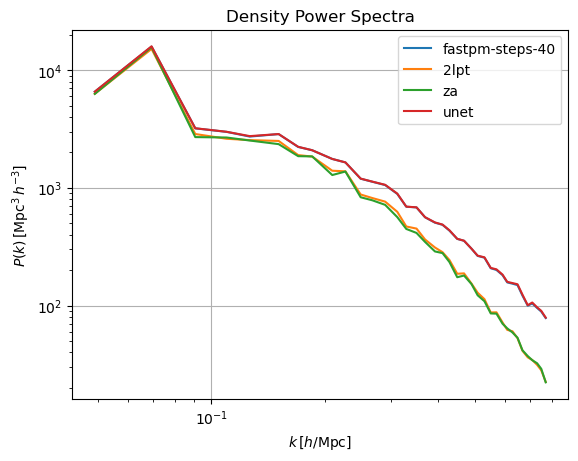

/tmp/ipykernel_1525945/4245589881.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k_values, np.sqrt(power_values / power_values_list[0]), label=labels[i])  # Plot transfer function


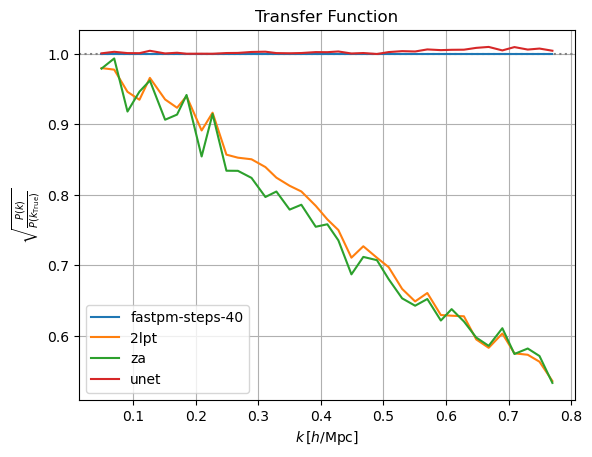

In [10]:
plt.figure()
for i, power_values in enumerate(power_values_list):
    plt.loglog(k_values, power_values, label=labels[i])  # Plot each power spectrum

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3 \, h^{-3}]$')
plt.legend()
plt.grid(True)
plt.title('Density Power Spectra')
plt.show()

# Second plot: Transfer function comparison
plt.figure()
for i, power_values in enumerate(power_values_list):
    if i == 0:
        plt.axhline(y=1, color='gray', linestyle=':', linewidth=1.5)  # Dotted line at y=1
    plt.plot(k_values, np.sqrt(power_values / power_values_list[0]), label=labels[i])  # Plot transfer function

# Move formatting functions outside the loop
#plt.ylim(0.6, 1.4)
#plt.xlim(0.0, 0.3)
plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\sqrt{\frac{P(k)}{P(k_{\mathrm{True}})}}$')
plt.legend()
plt.grid(True)
plt.title('Transfer Function')
plt.show()

In [78]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import argparse
from nbodykit.lab import *
from pmesh.pm import ParticleMesh
from matplotlib.gridspec import GridSpec

dk = 0.02

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

def getPow(data1,data2=None):
    pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
    q = pm.generate_uniform_particle_grid(shift=0.5)
    den1 = pm.paint(q+data1.reshape([-1,3]))
    if(data2 is not None):
        pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
        den2 = pm.paint(q+data2.reshape([-1,3]))
        temp = FFTPower(first=den1, second=den2,mode='1d',BoxSize=128,dk=dk)
        k,powspec = temp.power['k'],temp.power['power']
    else:
        temp = FFTPower(den1, mode='1d',BoxSize=128,dk=dk)
        k,powspec = temp.power['k'],temp.power['power']
    return [k,powspec.real]

def getPow_dis(data1,data2=None):
    pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
    q = pm.generate_uniform_particle_grid(shift=0.5)
    den1 = pm.paint(q)
    power = 0
    if(data2 is not None):
        pm = ParticleMesh(BoxSize=128, Nmesh=[32, 32, 32])
        q = pm.generate_uniform_particle_grid(shift=0.5)
        den2 = pm.paint(q)
        for ii in range(3):
            den1[:] = data1[:,:,:,ii]
            den2[:] = data2[:,:,:,ii]
            temp = FFTPower(first = den1, second = den2, mode='1d',BoxSize=128,dk=dk)
            k,power = temp.power['k'], power+temp.power['power']
    else:
        for ii in range(3):
            den1[:] = data1[:,:,:,ii]
            temp = FFTPower(den1, mode='1d',BoxSize=128,dk=dk)
            k,power = temp.power['k'], power+temp.power['power']
    return [k,power.real]

def getPow_ave(test,LPT,Nbody,d):
    powLPT,powNbody,powRecon,powReconxNbody,powLPTxNbody = 0,0,0,0,0
    if(d==1):
        k,P = getPow_dis(LPT)
        powLPT += P
        k,P = getPow_dis(Nbody)
        powNbody += P
        k,P = getPow_dis(test)
        powRecon += P
        k,P = getPow_dis(test,Nbody)
        powReconxNbody += P
        k,P = getPow_dis(LPT,Nbody)
        powLPTxNbody += P
    else:
        k,P = getPow(LPT)
        powLPT += P
        k,P = getPow(Nbody)
        powNbody += P
        k,P = getPow(test)
        powRecon += P
        k,P = getPow(test,Nbody)
        powReconxNbody += P
        k,P = getPow(LPT,Nbody)
        powLPTxNbody += P
    return k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody

def plot_pow(k, powNbody, powLPT, powRecon, LxN, RxN, title, 
             stdLPT=None, stdRecon=None, stdNbody=None, 
             stdLxN=None, stdRxN=None):
    fig = plt.figure(figsize=(6, 8))

    # First subplot
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    plt.plot(k, powLPT, label='2LPT')
    #if stdLPT is not None:
        #plt.fill_between(k, powLPT - stdLPT, powLPT + stdLPT, color='blue', alpha=0.2)
    
    plt.plot(k, powRecon, label='U-Net')
    #if stdRecon is not None:
        #plt.fill_between(k, powRecon - stdRecon, powRecon + stdRecon, color='orange', alpha=0.2)
    
    plt.plot(k, powNbody, label='fastPM')
    #if stdNbody is not None:
        #plt.fill_between(k, powNbody - stdNbody, powNbody + stdNbody, color='green', alpha=0.2)
    
    plt.ylabel('P(k)')
    plt.yscale('log')
    plt.legend(loc='lower left')
    plt.title(title)
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Second subplot
    ax2 = plt.subplot2grid((4, 1), (2, 0), rowspan=1, sharex=ax1)
    plt.axhline(y=1, color='k', linestyle='--')
    
    LPT_ratio = powLPT / powNbody
    Recon_ratio = powRecon / powNbody
    
    plt.plot(k, LPT_ratio, label='LPT')
    if stdNbody is not None:
        dLPT_ratio = LPT_ratio * np.sqrt((stdLPT / powLPT)**2 + (stdNbody / powNbody)**2)
        #plt.fill_between(k, LPT_ratio - dLPT_ratio, LPT_ratio + dLPT_ratio, color='blue', alpha=0.2)

    plt.plot(k, Recon_ratio, label='Predict')
    if stdNbody is not None:
        dRecon_ratio = Recon_ratio * np.sqrt((stdRecon / powRecon)**2 + (stdNbody / powNbody)**2)
        #plt.fill_between(k, Recon_ratio - dRecon_ratio, Recon_ratio + dRecon_ratio, color='orange', alpha=0.2)

    plt.ylabel(r'$T(k)$')
    plt.setp(ax2.get_xticklabels(), visible=False)

    # Third subplot
    ax3 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1)
    
    LPTxNbody = 1 - (LxN / np.sqrt(powLPT * powNbody)) ** 2
    ReconxNbody = 1 - (RxN / np.sqrt(powRecon * powNbody)) ** 2

    plt.loglog(k, LPTxNbody, label='LPTxNbody')
    if stdNbody is not None:
        dLPTxNbody = np.sqrt(
            ((LxN * (-1 / (2 * np.sqrt(powLPT * powNbody))) * (1 / np.sqrt(powLPT))) * stdLPT) ** 2 +
             ((LxN * (-1 / (2 * np.sqrt(powLPT * powNbody))) * (1 / np.sqrt(powNbody))) * stdNbody) ** 2 +
             ((1 / np.sqrt(powLPT * powNbody)) * stdLxN) ** 2)
        #plt.fill_between(k, LPTxNbody - dLPTxNbody, LPTxNbody + dLPTxNbody, color='blue', alpha=0.2)

    plt.loglog(k, ReconxNbody, label='ReconxNbody')
    if stdNbody is not None:
        dReconxNbody = np.sqrt(
            ((RxN * (-1 / (2 * np.sqrt(powRecon * powNbody))) * (1 / np.sqrt(powRecon))) * stdRecon) ** 2 +
             ((RxN * (-1 / (2 * np.sqrt(powRecon * powNbody))) * (1 / np.sqrt(powNbody))) * stdNbody) ** 2 +
             ((1 / np.sqrt(powRecon * powNbody)) * stdRxN) ** 2)
        #plt.fill_between(k, ReconxNbody - dReconxNbody, ReconxNbody + dReconxNbody, color='orange', alpha=0.2)

    plt.xticks(np.round([0.06 + 0.01 * i for i in range(0, 4, 2)] + 
                         [0.1 + 0.1 * i for i in range(0, 7, 2)], 2),
               np.round([0.06 + 0.01 * i for i in range(0, 4, 2)] + 
                         [0.1 + 0.1 * i for i in range(0, 7, 2)], 2))
    plt.xticks(rotation=45)
    plt.ylabel(r'1-$r^2$')
    plt.legend()
    plt.show()

/tmp/ipykernel_1669594/3737795662.py:105: RuntimeWarning: invalid value encountered in true_divide
  LPT_ratio = powLPT / powNbody
/tmp/ipykernel_1669594/3737795662.py:106: RuntimeWarning: invalid value encountered in true_divide
  Recon_ratio = powRecon / powNbody
/tmp/ipykernel_1669594/3737795662.py:124: RuntimeWarning: invalid value encountered in true_divide
  LPTxNbody = 1 - (LxN / np.sqrt(powLPT * powNbody)) ** 2
/tmp/ipykernel_1669594/3737795662.py:125: RuntimeWarning: invalid value encountered in true_divide
  ReconxNbody = 1 - (RxN / np.sqrt(powRecon * powNbody)) ** 2


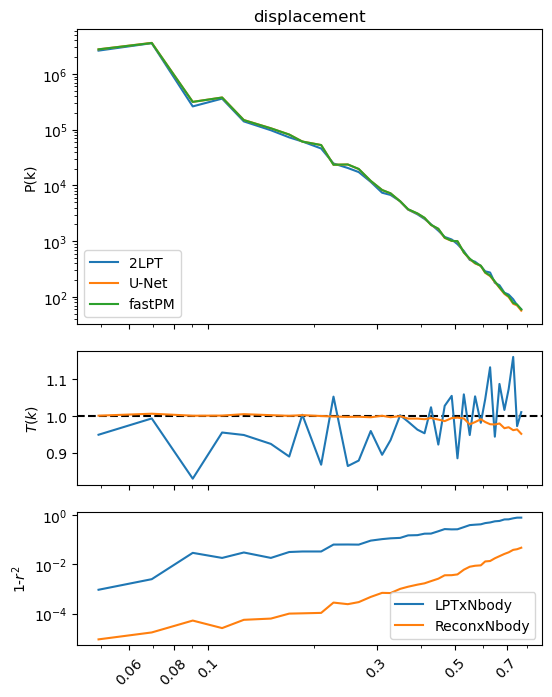

In [79]:
%matplotlib inline
fastpm_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,0:3]

k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody = getPow_ave(test=unet_displacement,LPT=za_displacement,Nbody=fastpm_displacement,d=1)
plot_pow(k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody,'displacement')

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5
/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/tmp/ipykernel_1669594/3737795662.py:105: RuntimeWarning: invalid value encountered in true_divide
  LPT_ratio = powLPT / powNbody
/tmp/ipykernel_1669594/3737795662.py:106: RuntimeWarning: invalid value encountered in true_divide
  Recon_ratio = powRecon / powNbody
/tmp/ipykernel_1669594/3737795662.py:110: RuntimeWarning: invalid value encountered in true_divide
  dLPT_ratio = LPT_ratio * np.sqrt((stdLPT / powLPT)**2 + (stdNbody

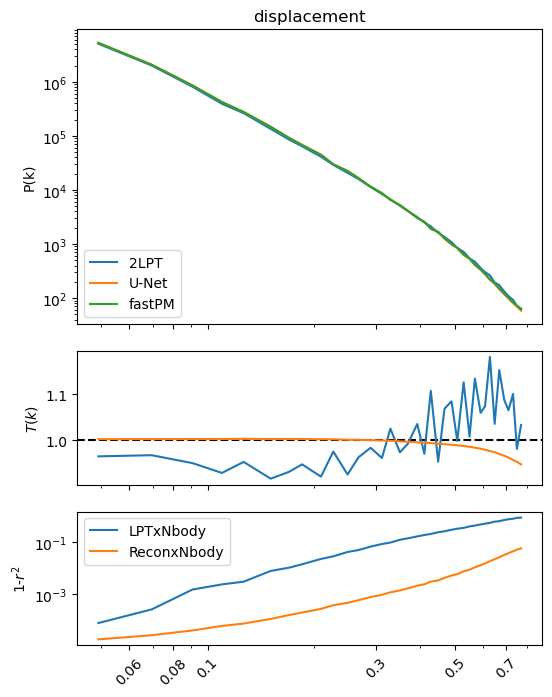

In [90]:
%matplotlib inline
import torch
from model1021 import Lpt2NbodyNetLightning

model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()

powNbody_list = []
powLPT_list = []
powRecon_list = []
powLPTxNbody_list = []
powReconxNbody_list = []

for i, seed in enumerate(seeds):
    fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_names[i]+'/fastpm_0.0099', dataset='1/', header='Header')
    fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

    pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

    za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
    twolpt_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,3:6]
    fastpm_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,0:3]
    za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)
    unet_displacement = model(za_tensor)

    unet_displacement = unet_displacement.squeeze(0).permute(1, 2, 3, 0).detach().numpy()

    k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody = getPow_ave(test=unet_displacement,LPT=twolpt_displacement,Nbody=fastpm_displacement,d=1)
    powNbody_list.append(powNbody)
    powLPT_list.append(powLPT)
    powRecon_list.append(powRecon)
    powLPTxNbody_list.append(powLPTxNbody)
    powReconxNbody_list.append(powReconxNbody)

    # Convert lists to NumPy arrays for easier manipulation
    powNbody_array = np.array(powNbody_list)
    powLPT_array = np.array(powLPT_list)
    powRecon_array = np.array(powRecon_list)
    powLPTxNbody_array = np.array(powLPTxNbody_list)
    powReconxNbody_array = np.array(powReconxNbody_list)


# Calculate the average and standard deviation
powNbody = np.mean(powNbody_array, axis=0)
stdNbody = np.std(powNbody_array, axis=0)

powLPT = np.mean(powLPT_array, axis=0)
stdLPT = np.std(powLPT_array, axis=0)

powRecon = np.mean(powRecon_array, axis=0)
stdRecon = np.std(powRecon_array, axis=0)

LxN = np.mean(powLPTxNbody_array, axis=0)
stdLxN = np.std(powLPTxNbody_array, axis=0)

RxN = np.mean(powReconxNbody_array, axis=0)
stdRxN = np.std(powReconxNbody_array, axis=0)

plot_pow(k, powNbody, powLPT, powRecon, LxN, RxN, 'displacement', stdLPT, stdRecon, stdNbody, stdLxN, stdRxN)


/tmp/ipykernel_1669594/3737795662.py:105: RuntimeWarning: invalid value encountered in true_divide
  LPT_ratio = powLPT / powNbody
/tmp/ipykernel_1669594/3737795662.py:106: RuntimeWarning: invalid value encountered in true_divide
  Recon_ratio = powRecon / powNbody
/tmp/ipykernel_1669594/3737795662.py:124: RuntimeWarning: invalid value encountered in true_divide
  LPTxNbody = 1 - (LxN / np.sqrt(powLPT * powNbody)) ** 2
/tmp/ipykernel_1669594/3737795662.py:125: RuntimeWarning: invalid value encountered in true_divide
  ReconxNbody = 1 - (RxN / np.sqrt(powRecon * powNbody)) ** 2


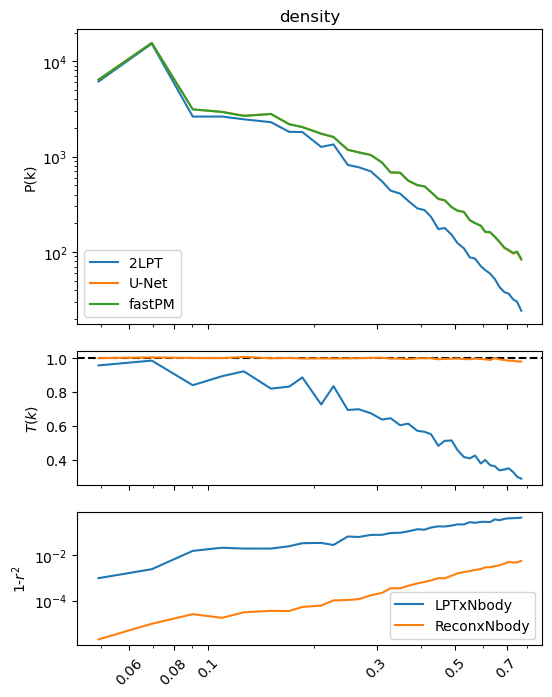

In [80]:
%matplotlib inline
k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody = getPow_ave(test=unet_displacement,LPT=za_displacement,Nbody=fastpm_displacement,d=0)
plot_pow(k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody,'density')

/tmp/ipykernel_1669594/3737795662.py:105: RuntimeWarning: invalid value encountered in true_divide
  LPT_ratio = powLPT / powNbody
/tmp/ipykernel_1669594/3737795662.py:106: RuntimeWarning: invalid value encountered in true_divide
  Recon_ratio = powRecon / powNbody
/tmp/ipykernel_1669594/3737795662.py:110: RuntimeWarning: invalid value encountered in true_divide
  dLPT_ratio = LPT_ratio * np.sqrt((stdLPT / powLPT)**2 + (stdNbody / powNbody)**2)
/tmp/ipykernel_1669594/3737795662.py:115: RuntimeWarning: invalid value encountered in true_divide
  dRecon_ratio = Recon_ratio * np.sqrt((stdRecon / powRecon)**2 + (stdNbody / powNbody)**2)
/tmp/ipykernel_1669594/3737795662.py:124: RuntimeWarning: invalid value encountered in true_divide
  LPTxNbody = 1 - (LxN / np.sqrt(powLPT * powNbody)) ** 2
/tmp/ipykernel_1669594/3737795662.py:125: RuntimeWarning: invalid value encountered in true_divide
  ReconxNbody = 1 - (RxN / np.sqrt(powRecon * powNbody)) ** 2
/tmp/ipykernel_1669594/3737795662.py:130: 

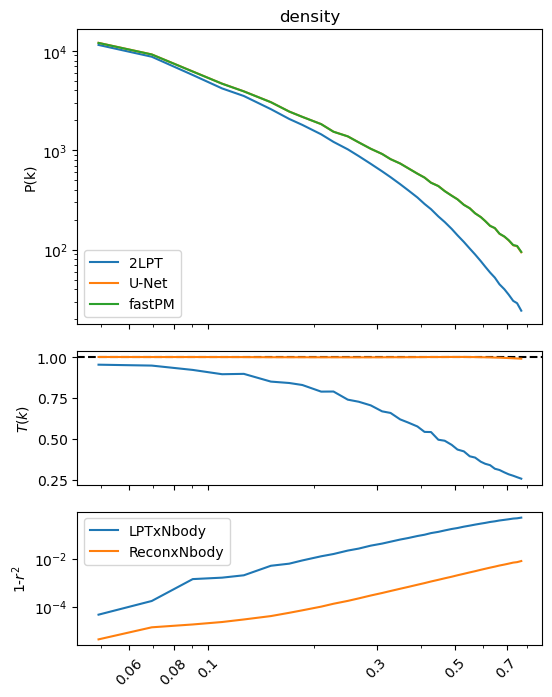

In [91]:
%matplotlib inline
import torch
from model1021 import Lpt2NbodyNetLightning

model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()

powNbody_list = []
powLPT_list = []
powRecon_list = []
powLPTxNbody_list = []
powReconxNbody_list = []

for i, seed in enumerate(seeds):
    fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_names[i]+'/fastpm_0.0099', dataset='1/', header='Header')
    fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

    pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

    za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
    twolpt_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,3:6]
    fastpm_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,0:3]
    za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)
    unet_displacement = model(za_tensor)

    unet_displacement = unet_displacement.squeeze(0).permute(1, 2, 3, 0).detach().numpy()

    k,powNbody,powLPT,powRecon,powLPTxNbody,powReconxNbody = getPow_ave(test=unet_displacement,LPT=twolpt_displacement,Nbody=fastpm_displacement,d=0)
    powNbody_list.append(powNbody)
    powLPT_list.append(powLPT)
    powRecon_list.append(powRecon)
    powLPTxNbody_list.append(powLPTxNbody)
    powReconxNbody_list.append(powReconxNbody)

    # Convert lists to NumPy arrays for easier manipulation
    powNbody_array = np.array(powNbody_list)
    powLPT_array = np.array(powLPT_list)
    powRecon_array = np.array(powRecon_list)
    powLPTxNbody_array = np.array(powLPTxNbody_list)
    powReconxNbody_array = np.array(powReconxNbody_list)


# Calculate the average and standard deviation
powNbody = np.mean(powNbody_array, axis=0)
stdNbody = np.std(powNbody_array, axis=0)

powLPT = np.mean(powLPT_array, axis=0)
stdLPT = np.std(powLPT_array, axis=0)

powRecon = np.mean(powRecon_array, axis=0)
stdRecon = np.std(powRecon_array, axis=0)

LxN = np.mean(powLPTxNbody_array, axis=0)
stdLxN = np.std(powLPTxNbody_array, axis=0)

RxN = np.mean(powReconxNbody_array, axis=0)
stdRxN = np.std(powReconxNbody_array, axis=0)

plot_pow(k, powNbody, powLPT, powRecon, LxN, RxN, 'density', stdLPT, stdRecon, stdNbody, stdLxN, stdRxN)

In [81]:
import torch

fastpm_initial_part = BigFileCatalog('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/'+fastpm_folder_name+'/fastpm_0.0099', dataset='1/', header='Header')
fastpm_initial_mesh = fastpm_initial_part.to_mesh(Nmesh=32,BoxSize=128)

pos_initial = fastpm_initial_part['Position'].compute().reshape(32, 32, 32, 3).transpose(3, 0, 1, 2)

za_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,6:9]
twolpt_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,3:6]
fastpm_displacement = np.load('/lustre/project/tkcastrosim/CKWan/fastpm-master/mlsim/data_collection/mlsimdata_npy2/'+folder+'/'+seed+'.npy')[:,:,:,0:3]
za_tensor = torch.tensor(za_displacement, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)

from model1021 import Lpt2NbodyNetLightning
model = Lpt2NbodyNetLightning.load_from_checkpoint(model_path)
model.eval()
unet_displacement = model(za_tensor)

unet_displacement = unet_displacement.squeeze(0).permute(1, 2, 3, 0).detach().numpy()

/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/users/s1155175795/.conda/envs/evaluation/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


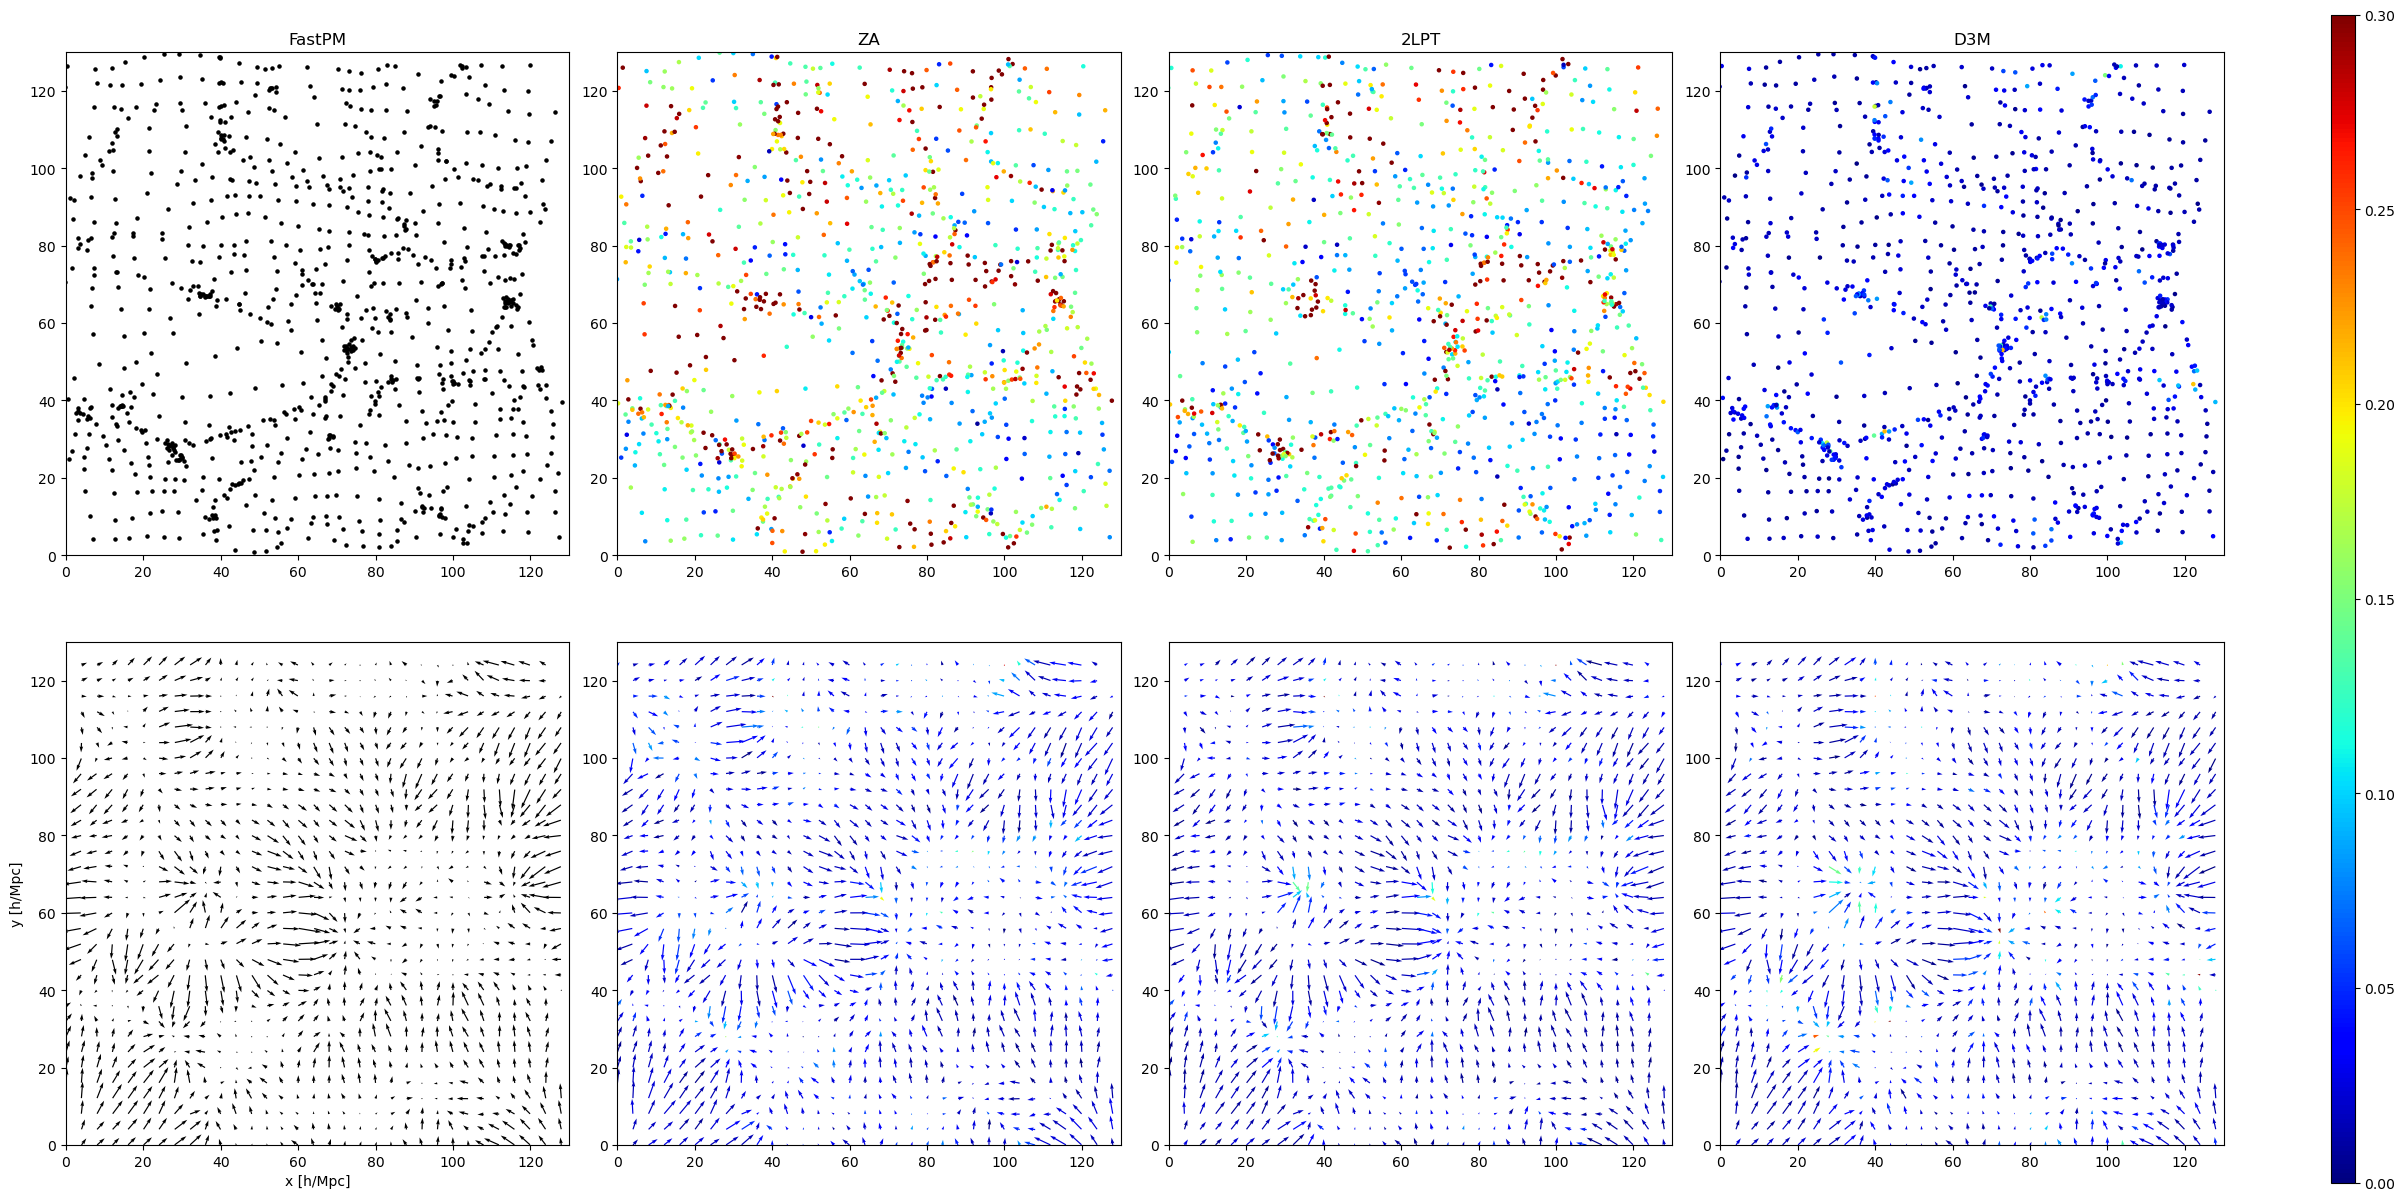

In [89]:
# Slice in z direction
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these arrays
# initial_positions: (32, 32, 32, 3)
# displacement_fields: (32, 32, 32, 3) for each of the four modes

grid_size = 32

# Select a slice to visualize (e.g., at z = grid_size // 2)
slice_index = 16

# Random initial positions
initial_positions = pos_initial.transpose(1, 2, 3, 0)

displacement_za = za_displacement
displacement_lpt = twolpt_displacement
displacement_fastpm = fastpm_displacement
displacement_dm = unet_displacement
# Calculate final positions
final_positions_fastpm = initial_positions + displacement_fastpm
final_positions_za = initial_positions + displacement_za
final_positions_lpt = initial_positions + displacement_lpt
final_positions_dm = initial_positions + displacement_dm

def relative_error(fastpm, other):
    # Compute the Euclidean distance between the two 3D positions
    error = (other-fastpm)
    error = np.linalg.norm(error, axis=-1) / np.linalg.norm(fastpm, axis=-1)
    return error

# Calculate relative errors for the final positions
rel_error_za = relative_error(displacement_fastpm[:, :, slice_index], displacement_za[:, :, slice_index])

rel_error_lpt = relative_error(displacement_fastpm[:, :, slice_index], displacement_lpt[:, :, slice_index])

rel_error_dm = relative_error(displacement_fastpm[:, :, slice_index], displacement_dm[:, :, slice_index])

# Create plots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)

# Final particle positions for FastPM
axs[0, 0].scatter(final_positions_fastpm[:, :, slice_index, 0], final_positions_fastpm[:, :, slice_index, 1], 
                   c='black', s=5)
axs[0, 0].set_title('FastPM')

# Displacement field with relative error coloring (FastPM vs ZA)
sc1 = axs[0, 1].scatter(final_positions_za[:, :, slice_index, 0], final_positions_za[:, :, slice_index, 1], 
                         c=rel_error_za, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 1].set_title('ZA')

# Displacement field with relative error coloring (FastPM vs 2LPT)
sc2 = axs[0, 2].scatter(final_positions_lpt[:, :, slice_index, 0], final_positions_lpt[:, :, slice_index, 1], 
                        c=rel_error_lpt, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 2].set_title('2LPT')

# Displacement field with relative error coloring (FastPM vs D3M)
sc3 = axs[0, 3].scatter(final_positions_dm[:, :, slice_index, 0], final_positions_dm[:, :, slice_index, 1], 
                        c=rel_error_dm, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 3].set_title('D3M')

# Calculate relative error for the displacement vectors
rel_error_vectors_za = relative_error(displacement_fastpm[:, :, slice_index], displacement_za[:, :, slice_index])

rel_error_vectors_lpt = relative_error(displacement_fastpm[:, :, slice_index], displacement_lpt[:, :, slice_index])

rel_error_vectors_dm = relative_error(displacement_fastpm[:, :, slice_index], displacement_dm[:, :, slice_index])

# Vector field of the displacement field
Y, X = initial_positions[:, :, slice_index, 1], initial_positions[:, :, slice_index, 0]  # Use initial positions
U = displacement_fastpm[:, :, slice_index, 0]
V = displacement_fastpm[:, :, slice_index, 1]

# Create the quiver plot with colored vectors
quiver = axs[1, 0].quiver(X, Y, U, V, color='black')
axs[1, 0].set_xlabel('x [h/Mpc]')
axs[1, 0].set_ylabel('y [h/Mpc]')

# Vector field for another displacement method (e.g., ZA)
U_za = displacement_za[:, :, slice_index, 0]
V_za = displacement_za[:, :, slice_index, 1]

# Create the quiver plot for ZA with colored vectors
quiver_za = axs[1, 1].quiver(X, Y, U_za, V_za, rel_error_vectors_za, cmap=plt.cm.jet)

U_lpt = displacement_lpt[:, :, slice_index, 0]
V_lpt = displacement_lpt[:, :, slice_index, 1]

# Create the quiver plot for ZA with colored vectors
quiver_lpt = axs[1, 2].quiver(X, Y, U_lpt, V_lpt, rel_error_vectors_lpt, cmap=plt.cm.jet)

U_dm = displacement_dm[:, :, slice_index, 0]
V_dm = displacement_dm[:, :, slice_index, 1]
# Create the quiver plot for ZA with colored vectors
quiver_dm = axs[1, 3].quiver(X, Y, U_dm, V_dm, rel_error_vectors_dm, cmap=plt.cm.jet)

for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(0, 130)
    ax.set_ylim(0, 130)

fig.colorbar(sc3, ax=axs.ravel().tolist(), aspect=50)

plt.show()

In [86]:
print(rel_error_vectors_za.mean())
print(rel_error_vectors_lpt.mean())
print(rel_error_vectors_dm.mean())

0.20393988
0.1701265
0.025032941


In [87]:
print(rel_error_vectors_za.max())
print(rel_error_vectors_lpt.max())
print(rel_error_vectors_dm.max())

1.7617855
1.7792547
0.21381989


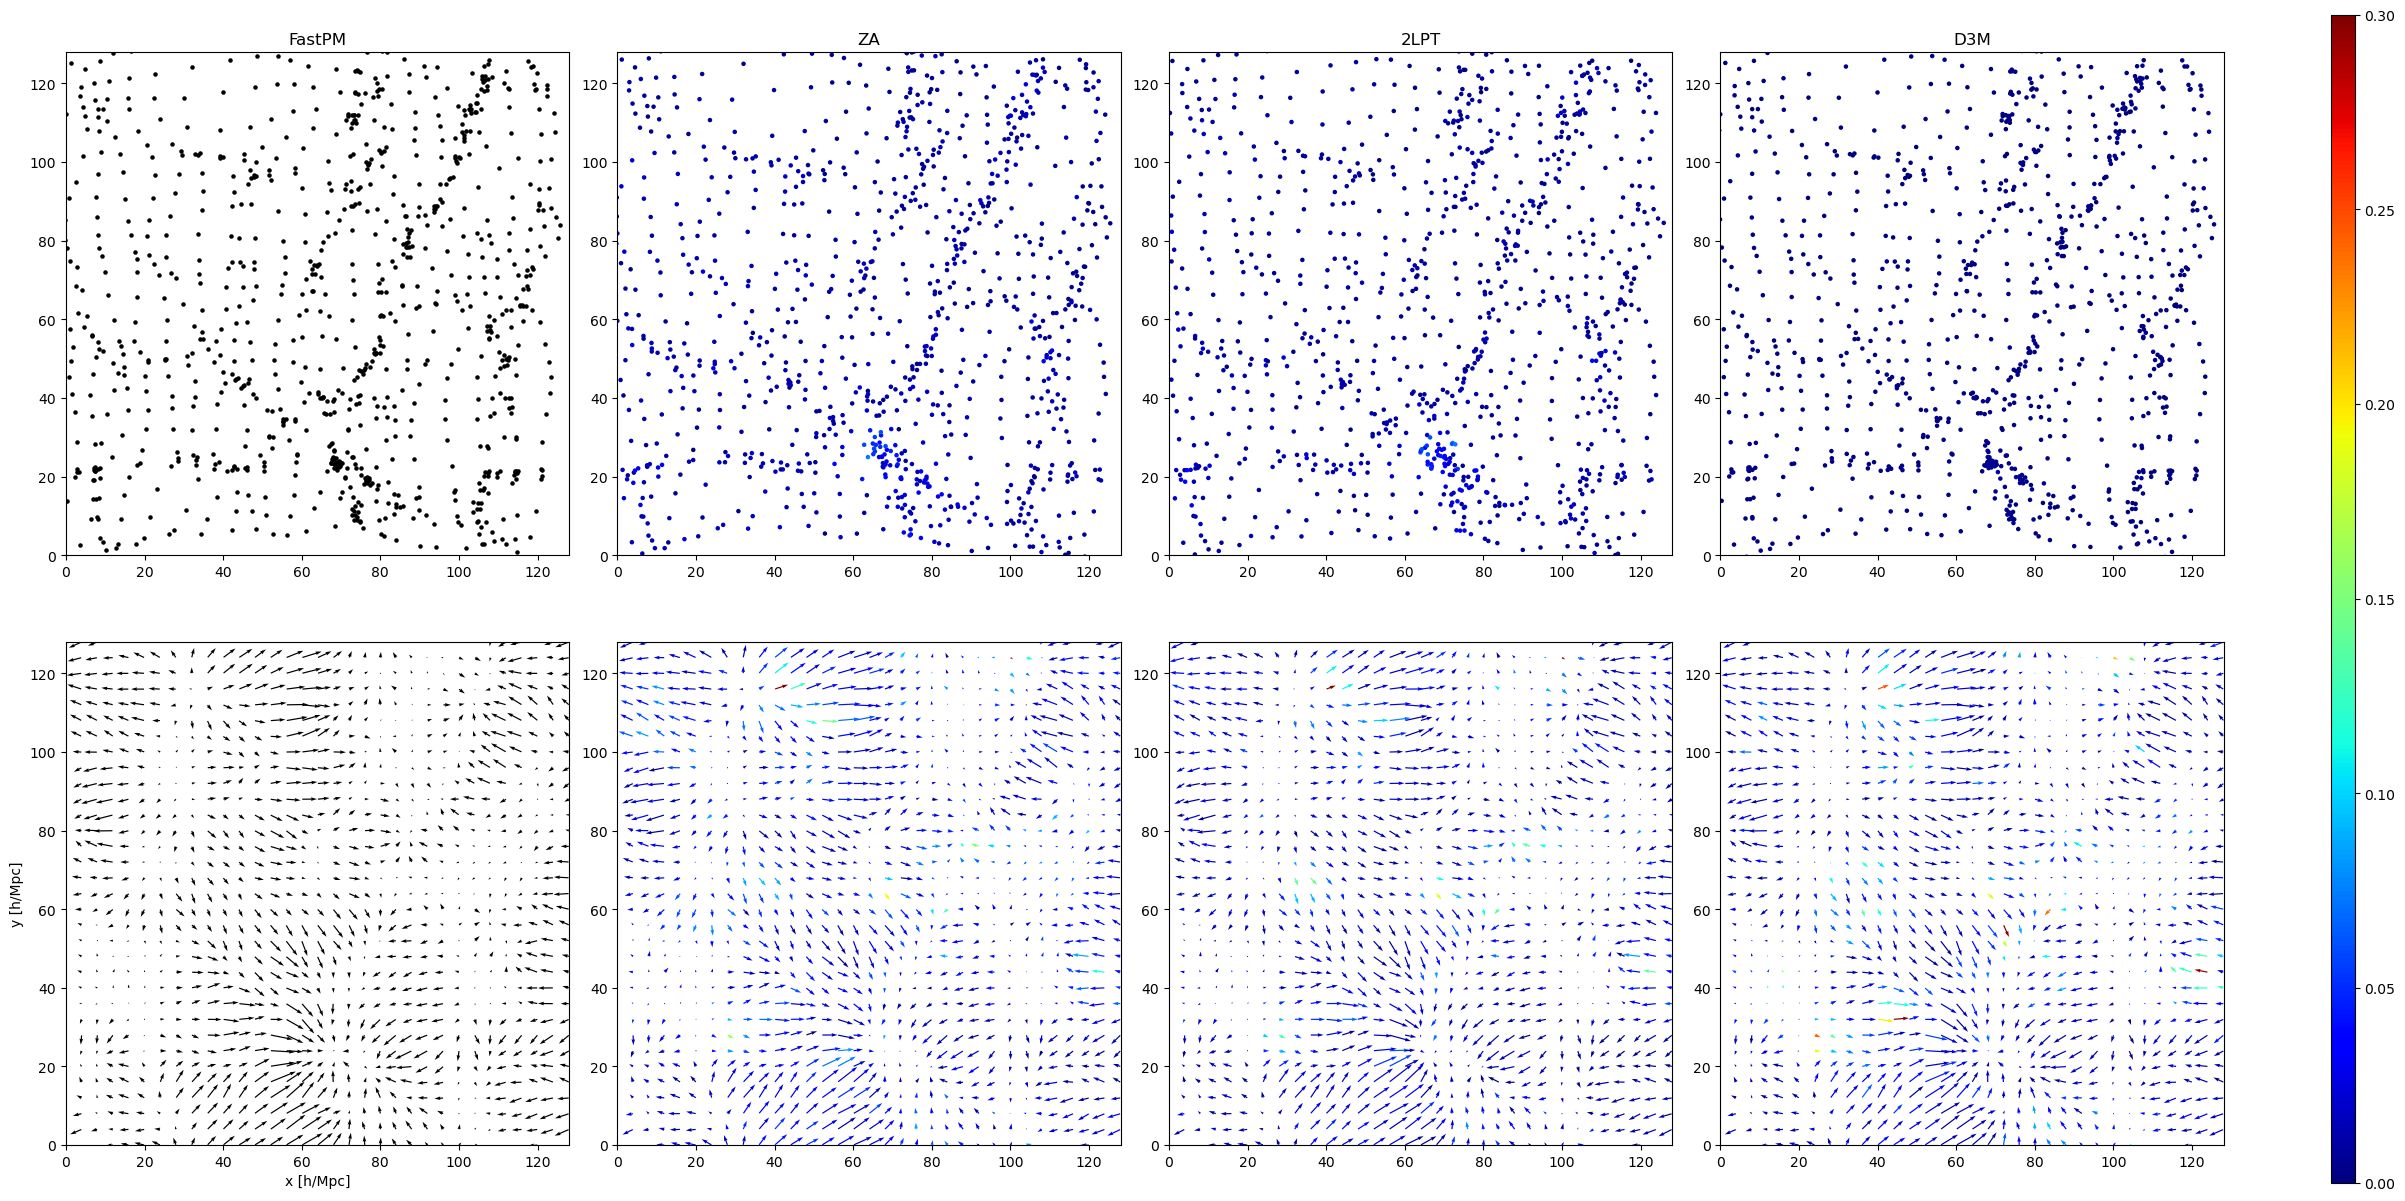

In [88]:
# Slice in y-direction
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these arrays
# initial_positions: (32, 32, 32, 3)
# displacement_fields: (32, 32, 32, 3) for each of the four modes

grid_size = 32

# Select a slice to visualize (e.g., at z = grid_size // 2)
slice_index = 20

# Random initial positions
initial_positions = pos_initial.transpose(1, 2, 3, 0)

displacement_za = za_displacement
displacement_lpt = twolpt_displacement
displacement_fastpm = fastpm_displacement
displacement_dm = unet_displacement
# Calculate final positions
final_positions_fastpm = initial_positions + displacement_fastpm
final_positions_za = initial_positions + displacement_za
final_positions_lpt = initial_positions + displacement_lpt
final_positions_dm = initial_positions + displacement_dm

def relative_error(fastpm, other):
    # Compute the Euclidean distance between the two 3D positions
    diff = np.linalg.norm(fastpm - other, axis=-1)  # Euclidean distance
    norm_fastpm = np.linalg.norm(fastpm, axis=-1)   # Norm of FastPM positions
    return diff / norm_fastpm

# Calculate relative errors for the final positions
rel_error_za = relative_error(final_positions_fastpm[:, slice_index, :], final_positions_za[:, slice_index, :])

rel_error_lpt = relative_error(final_positions_fastpm[:, slice_index, :], final_positions_lpt[:, slice_index, :])

rel_error_dm = relative_error(final_positions_fastpm[:, slice_index, :], final_positions_dm[:, slice_index, :])

# Create plots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)

# Final particle positions for FastPM
axs[0, 0].scatter(final_positions_fastpm[:, slice_index, :, 0], final_positions_fastpm[:, slice_index, :, 2], 
                   c='black', s=5)
axs[0, 0].set_title('FastPM')

# Displacement field with relative error coloring (FastPM vs ZA)
sc1 = axs[0, 1].scatter(final_positions_za[:, slice_index, :, 0], final_positions_za[:, slice_index, :, 2], 
                         c=rel_error_za, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 1].set_title('ZA')

# Displacement field with relative error coloring (FastPM vs 2LPT)
sc2 = axs[0, 2].scatter(final_positions_lpt[:, slice_index, :, 0], final_positions_lpt[:, slice_index, :, 2], 
                        c=rel_error_lpt, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 2].set_title('2LPT')

# Displacement field with relative error coloring (FastPM vs D3M)
sc3 = axs[0, 3].scatter(final_positions_dm[:, slice_index, :, 0], final_positions_dm[:, slice_index, :, 2], 
                        c=rel_error_dm, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 3].set_title('D3M')

# Calculate relative error for the displacement vectors
norm_rel_error_vectors_za = (rel_error_vectors_za.flatten() - np.min(rel_error_vectors_za.flatten())) / (np.max(rel_error_vectors_za.flatten()) - np.min(rel_error_vectors_za.flatten()))

norm_rel_error_vectors_lpt = (rel_error_vectors_lpt.flatten() - np.min(rel_error_vectors_lpt.flatten())) / (np.max(rel_error_vectors_lpt.flatten()) - np.min(rel_error_vectors_lpt.flatten()))

norm_rel_error_vectors_dm = (rel_error_vectors_dm.flatten() - np.min(rel_error_vectors_dm.flatten())) / (np.max(rel_error_vectors_dm.flatten()) - np.min(rel_error_vectors_dm.flatten()))

# Vector field of the displacement field
Z, X = initial_positions[:, slice_index, :, 2], initial_positions[:, slice_index, :, 0]  # Use initial positions
U = displacement_fastpm[:, slice_index, :, 0]
W = displacement_fastpm[:, slice_index, :, 2]

# Create the quiver plot with colored vectors
quiver = axs[1, 0].quiver(X, Z, U, W, color='black')
axs[1, 0].set_xlabel('x [h/Mpc]')
axs[1, 0].set_ylabel('y [h/Mpc]')

# Vector field for another displacement method (e.g., ZA)
U_za = displacement_za[:, slice_index, :, 0]
W_za = displacement_za[:, slice_index, :, 2]

# Create the quiver plot for ZA with colored vectors
quiver_za = axs[1, 1].quiver(X, Z, U_za, W_za, rel_error_vectors_za, cmap=plt.cm.jet)

U_lpt = displacement_lpt[:, slice_index, :, 0]
W_lpt = displacement_lpt[:, slice_index, :, 2]

# Create the quiver plot for 2lpt with colored vectors
quiver_lpt = axs[1, 2].quiver(X, Z, U_lpt, W_lpt, rel_error_vectors_lpt, cmap=plt.cm.jet)

U_dm = displacement_dm[:, slice_index, :, 0]
W_dm = displacement_dm[:, slice_index, :, 2]
# Create the quiver plot for d3m with colored vectors
quiver_dm = axs[1, 3].quiver(X, Z, U_dm, W_dm, rel_error_vectors_dm, cmap=plt.cm.jet)

for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(0, 128)
    ax.set_ylim(0, 128)

fig.colorbar(sc3, ax=axs.ravel().tolist(), aspect=50)

plt.show()

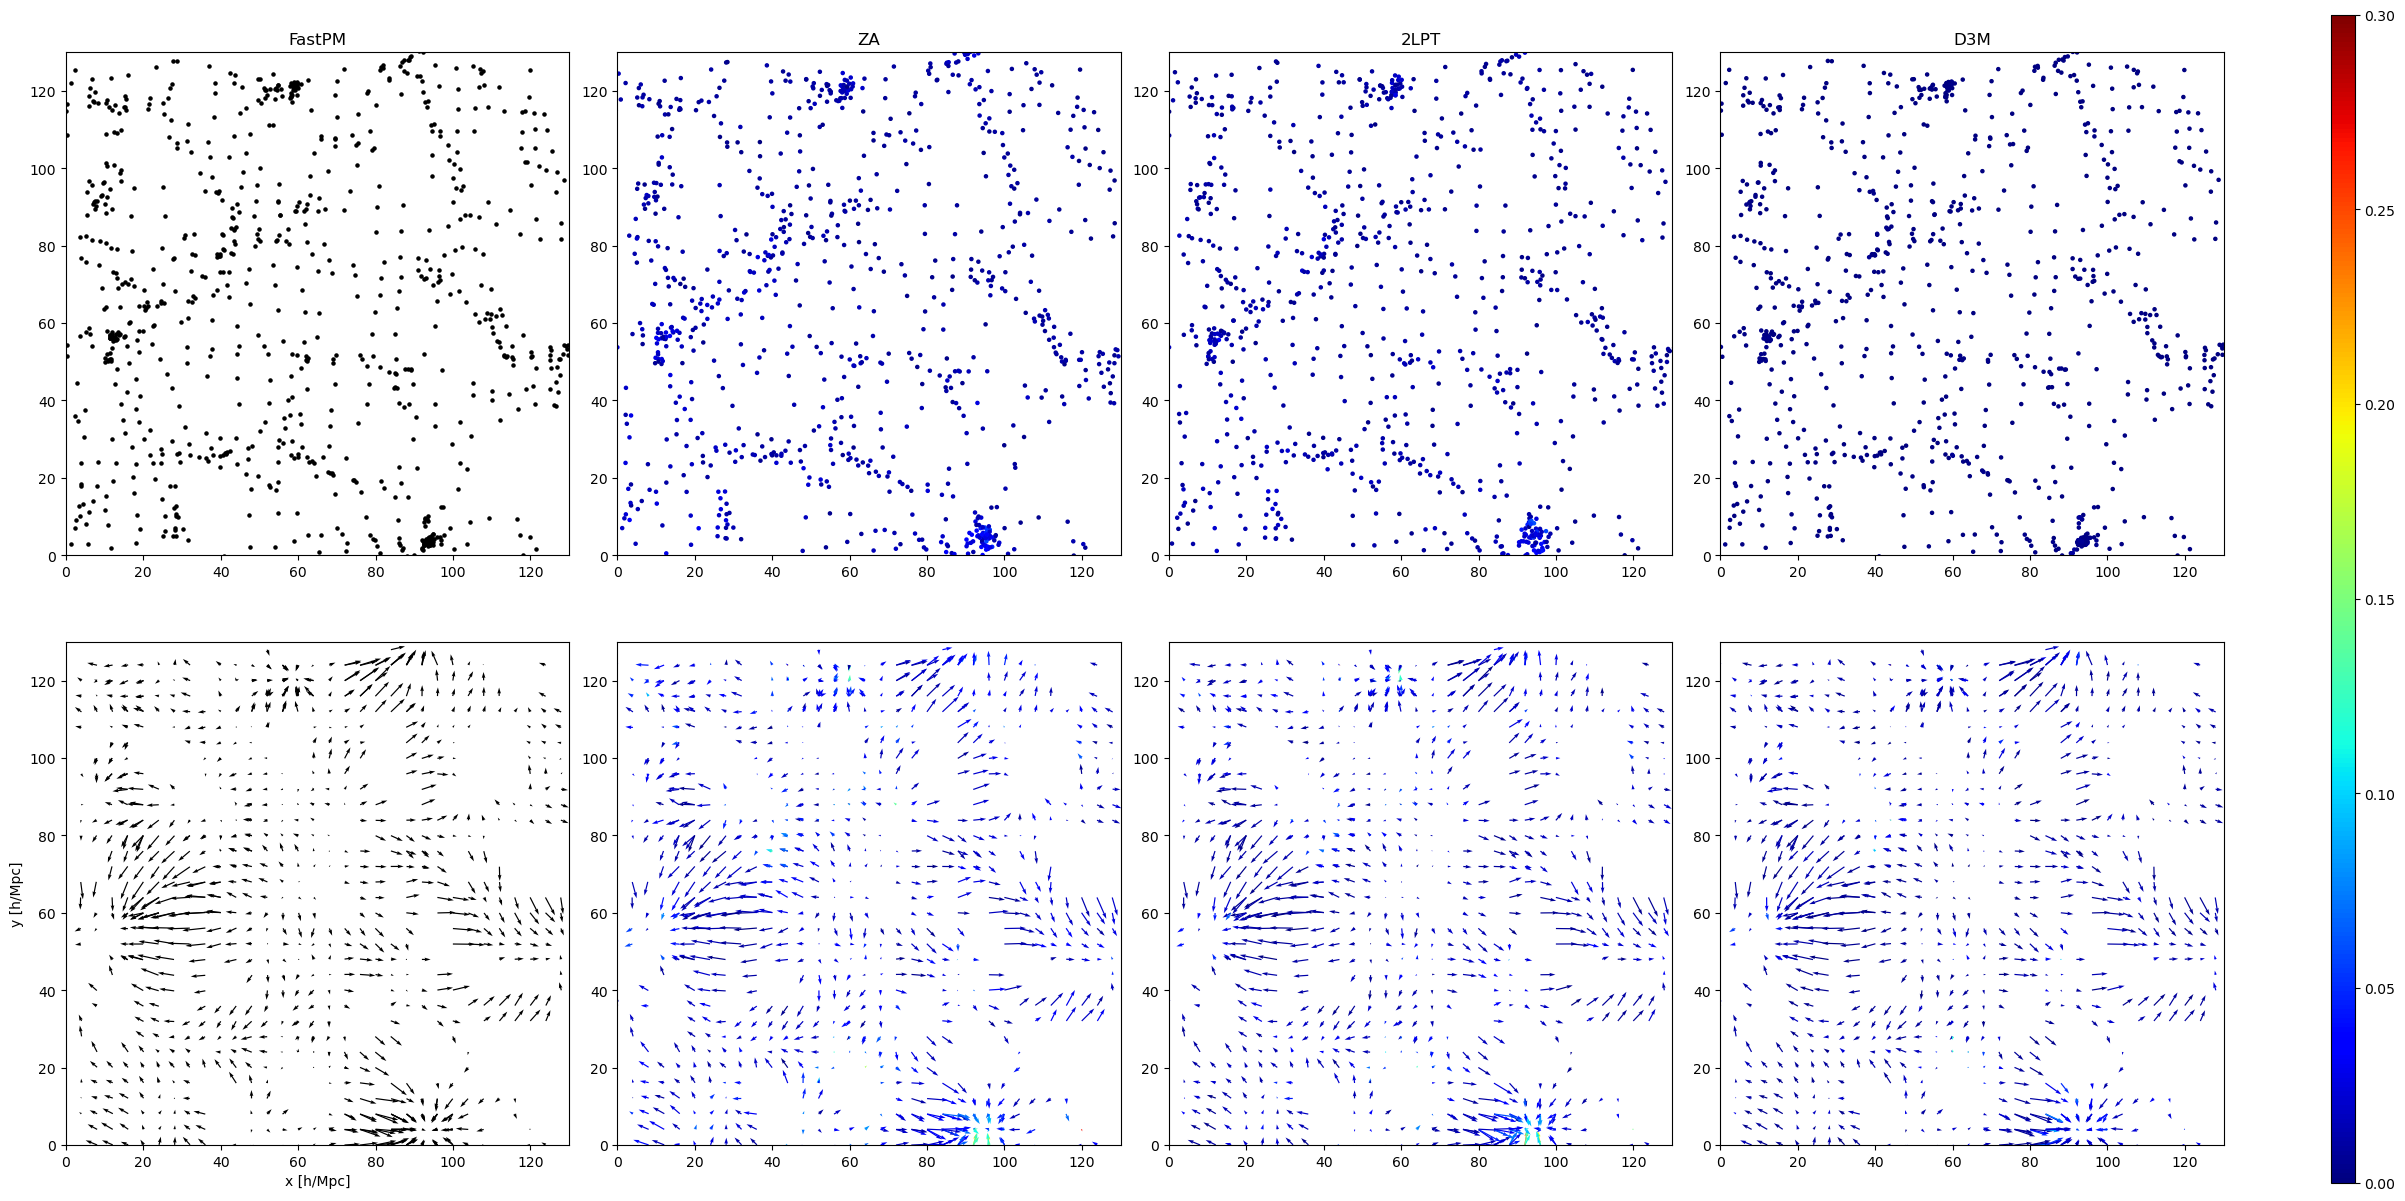

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have these arrays
# initial_positions: (32, 32, 32, 3)
# displacement_fields: (32, 32, 32, 3) for each of the four modes

grid_size = 32

# Choose the actual z-value for the slice
z_slice_value = 64  # Example: slice at z = 50 Mpc/h
slice_width = 2     # Tolerance for z slice (e.g., ±5 Mpc/h)

# Random initial positions (shape: (32, 32, 32, 3))
initial_positions = pos_initial.transpose(1, 2, 3, 0)

# Displacement fields (shape: (32, 32, 32, 3))
displacement_za = za_displacement
displacement_lpt = twolpt_displacement
displacement_fastpm = fastpm_displacement
displacement_dm = unet_displacement

# Calculate final positions
final_positions_fastpm = initial_positions + displacement_fastpm
final_positions_za = initial_positions + displacement_za
final_positions_lpt = initial_positions + displacement_lpt
final_positions_dm = initial_positions + displacement_dm

def relative_error(fastpm, other):
    # Compute the Euclidean distance between the two 3D positions
    diff = np.linalg.norm(fastpm - other, axis=-1)  # Euclidean distance
    norm_fastpm = np.linalg.norm(fastpm, axis=-1)   # Norm of FastPM positions
    return diff / norm_fastpm

# Filter particles close to the desired z-value
z_final = final_positions_fastpm[:, :, :, 2]  # Extract the z-coordinates of final positions
slice_mask = (z_final > z_slice_value - slice_width) & (z_final < z_slice_value + slice_width)

# Apply the mask to get the particles in the slice
x_slice = final_positions_fastpm[:, :, :, 0][slice_mask]
y_slice = final_positions_fastpm[:, :, :, 1][slice_mask]

# Calculate relative errors for the final positions (for particles in the slice)
rel_error_za = relative_error(final_positions_fastpm[slice_mask], final_positions_za[slice_mask])
rel_error_lpt = relative_error(final_positions_fastpm[slice_mask], final_positions_lpt[slice_mask])
rel_error_dm = relative_error(final_positions_fastpm[slice_mask], final_positions_dm[slice_mask])

# Normalize relative errors for color mapping
norm_rel_error_za = (rel_error_za - np.min(rel_error_za)) / (np.max(rel_error_za) - np.min(rel_error_za))
norm_rel_error_lpt = (rel_error_lpt - np.min(rel_error_lpt)) / (np.max(rel_error_lpt) - np.min(rel_error_lpt))
norm_rel_error_dm = (rel_error_dm - np.min(rel_error_dm)) / (np.max(rel_error_dm) - np.min(rel_error_dm))

# Create plots
fig, axs = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)

# Final particle positions for FastPM
axs[0, 0].scatter(x_slice, y_slice, c='black', s=5)
axs[0, 0].set_title('FastPM')

# Displacement field with relative error coloring (FastPM vs ZA)
sc1 = axs[0, 1].scatter(final_positions_za[:, :, :, 0][slice_mask], final_positions_za[:, :, :, 1][slice_mask], 
                         c=rel_error_za, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 1].set_title('ZA')

# Displacement field with relative error coloring (FastPM vs 2LPT)
sc2 = axs[0, 2].scatter(final_positions_lpt[:, :, :, 0][slice_mask], final_positions_lpt[:, :, :, 1][slice_mask], 
                        c=rel_error_lpt, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 2].set_title('2LPT')

# Displacement field with relative error coloring (FastPM vs D3M)
sc3 = axs[0, 3].scatter(final_positions_dm[:, :, :, 0][slice_mask], final_positions_dm[:, :, :, 1][slice_mask], 
                        c=rel_error_dm, cmap=plt.cm.jet, vmin=0, vmax=0.3, s=5)
axs[0, 3].set_title('D3M')

# Vector field of the displacement field
Y, X = initial_positions[:, :, :, 1][slice_mask], initial_positions[:, :, :, 0][slice_mask]  # Use initial positions
U = displacement_fastpm[:, :, :, 0][slice_mask]
V = displacement_fastpm[:, :, :, 1][slice_mask]

quiver_za = axs[1, 0].quiver(X, Y, U, V, color='black')
axs[1, 0].set_xlabel('x [h/Mpc]')
axs[1, 0].set_ylabel('y [h/Mpc]')

# Calculate relative error for the displacement vectors (for particles in the slice)
rel_error_vectors_za = relative_error(displacement_fastpm[slice_mask], displacement_za[slice_mask])
rel_error_vectors_lpt = relative_error(displacement_fastpm[slice_mask], displacement_lpt[slice_mask])
rel_error_vectors_dm = relative_error(displacement_fastpm[slice_mask], displacement_dm[slice_mask])

U_za = displacement_za[:, :, :, 0][slice_mask]
V_za = displacement_za[:, :, :, 1][slice_mask]
# Create the quiver plot with colored vectors for FastPM vs ZA
quiver_za = axs[1, 1].quiver(X, Y, U_za, V_za, rel_error_vectors_za, cmap=plt.cm.jet)

# Vector field for 2LPT
U_lpt = displacement_lpt[:, :, :, 0][slice_mask]
V_lpt = displacement_lpt[:, :, :, 1][slice_mask]

# Create the quiver plot for 2LPT with colored vectors
quiver_lpt = axs[1, 2].quiver(X, Y, U_lpt, V_lpt, rel_error_vectors_lpt, cmap=plt.cm.jet)

# Vector field for D3M
U_dm = displacement_dm[:, :, :, 0][slice_mask]
V_dm = displacement_dm[:, :, :, 1][slice_mask]

# Create the quiver plot for D3M with colored vectors
quiver_dm = axs[1, 3].quiver(X, Y, U_dm, V_dm, rel_error_vectors_dm, cmap=plt.cm.jet)

for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(0, 130)
    ax.set_ylim(0, 130)

fig.colorbar(sc3, ax=axs.ravel().tolist(), aspect=50)

plt.show()


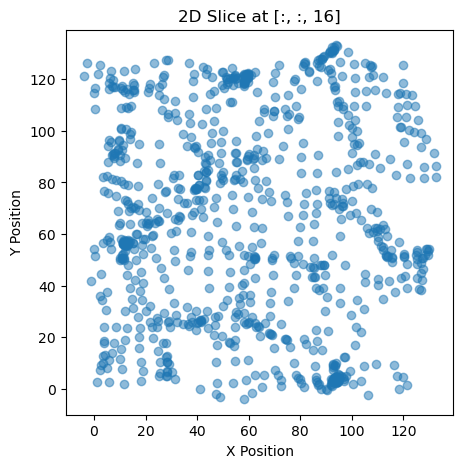

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the x, y, z components of positions

x = initial_positions[:,:,16, 0]
y = initial_positions[:,:,16, 0]

# Plotting the 2D slice
plt.figure(figsize=(5, 5))
plt.scatter(x_slice, y_slice, alpha=0.5)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title(f'2D Slice at [:, :, 16]')
plt.axis('equal')  # Optional: to maintain aspect ratio
plt.show()

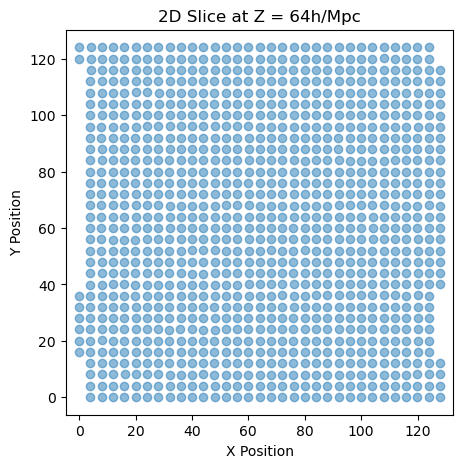

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the x, y, z components of positions
rinitial_positions = initial_positions.reshape(-1,3)
x = rinitial_positions[:, 0]
y = rinitial_positions[:, 1]
z = rinitial_positions[:, 2]

# Choose a z value to slice through
z_slice = 64  # Adjust this value based on your data range

# Create a mask for the points close to the chosen z value
tolerance = 2  # Adjust tolerance as needed
mask = (z >= z_slice - tolerance) & (z <= z_slice + tolerance)

# Filter x and y based on the mask
x_slice = x[mask]
y_slice = y[mask]

# Plotting the 2D slice
plt.figure(figsize=(5, 5))
plt.scatter(x_slice, y_slice, alpha=0.5)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title(f'2D Slice at Z = {z_slice}h/Mpc')
plt.axis('equal')  # Optional: to maintain aspect ratio
plt.show()